In [30]:
%pylab inline

import pandas as pd
import cPickle as pickle
from numpy import isnan
from nltk.corpus import stopwords

import networkx as nx
import matplotlib.pyplot as plt
import scipy
import scipy.stats

from textblob import Word
from textblob.base import BaseTokenizer
from textblob import TextBlob
from textblob import Blobber
from textblob.tokenizers import WordTokenizer

Populating the interactive namespace from numpy and matplotlib


In [3]:
data=pd.read_csv("Assignment 3 Edmunds Posts.csv", usecols=[0])

In [28]:
data['Posts'] = data['Posts'].map(lambda x: x.replace("LexusES","ES"))
data['Posts'] = data['Posts'].map(lambda x: x.replace("ES330","ES"))
data['Posts'] = data['Posts'].map(lambda x: x.replace("LS460","LS"))
data['Posts'] = data['Posts'].map(lambda x: x.replace("LS470","LS"))

data['Posts'] = data['Posts'].map(lambda x: x.replace("LexusLS","LS"))
data['Posts'] = data['Posts'].map(lambda x: x.replace("LexusRX","RX"))

In [5]:
sw=stopwords.words('english')

sw.remove('not')

models_skinny=["es","ls","rx","a8","a6","3series",\
               "5series","7series","xj","sclass"] 

In [6]:
def tKnzr (xstring):
    global sw
    tokens=list(TextBlob(str(xstring)).words)
    removeStopWords=[word for word in tokens if word.lower() not in sw]
    lemmaed=[Word(w).lemmatize() for w in removeStopWords]
    lowercase=[word.lower() for word in lemmaed]
    return lowercase

In [7]:
def finder (tokensList, modelList, numberWords):
    blanklist=[]
    for i in xrange(len(tokensList)):
        if tokensList[i] in modelList:
            blanklist.append(tokensList[i-numberWords:i+1+numberWords])
    return blanklist

In [22]:
def sentiment_compiler(postseries,modelsList,numberofwords):
    tb=Blobber(tokenizer=WordTokenizer())
    
    newseries=postseries.apply(tKnzr)
    newseries=newseries.apply(lambda x: finder(x,modelsList, numberofwords))
    newseries=newseries.apply(lambda x: [' '.join(inner) for inner in x])
    
    models=[" "+x+" " for x in modelsList]
    df=pd.DataFrame(columns=modelsList).join(newseries, how="outer")
    
    for index,l in enumerate(newseries):
        for string in l: #looping over all the strings in model_strings
                for model, model_skinny in zip(models,modelsList): #loop over all the models in model list
                    if model in string: #check if model is in a particular list
                        if isnan(df[model_skinny].iloc[index]): #correcting for neutral
                            df[model_skinny].iloc[index]=0
                        df[model_skinny].iloc[index]+=tb(string).sentiment[0]  
    return df

In [34]:
brands=['lexus','audi','bmw','jaguar','mercedes']

data['Posts'][0]
  
q=sentiment_compiler(data['Posts'],models_skinny,2)

In [46]:
q.to_csv('outputv4.csv')

In [39]:
#rawsentiment1 = pd.read_csv(r"C:\Users\Samruddhi Somani\Documents\McCombs\Fall\Text Mining\Text_Mining_MIS184N\Group_Assignment_3\outputv3.csv")

rawsentiment=q.drop(['Posts'],axis=1)

#rawsentiment = rawsentiment1.drop(['Unnamed: 0','model_strings'], axis=1)
#rawsentiment = rawsentiment1.drop('Unnamed: 0', axis=1) #Testing bejans
lab_for_C = ['ES', 'LS', 'RX', 'A8', 'A6', '3series', '5series', '7series', 'XJ', 'Sclass']
rawsentiment.columns = lab_for_C
rawsentiment = rawsentiment * 5
rawsentiment.replace(to_replace=0,value=0.0001, inplace=True)

In [40]:
#names = ['ES-LS','ES-RX','ES-A8','ES-A6','ES-3series','ES-5series','ES-7series','ES-XJ','ES-Sclass','LS-RX','LS-A8','LS-A6','LS-3series','LS-5series','LS-7series','LS-XJ','LS-Sclass','RX-A8','RX-A6','RX-3series','RX-5series','RX-7series','RX-XJ','RX-Sclass','A8-A6','A8-3series','A8-5series','A8-7series','A8-XJ','A8-Sclass','A6-3series','A6-5series','A6-7series','A6-XJ','A6-Sclass','3series-5series','3series-7series','3series-XJ','3series-Sclass','5series-7series','5series-XJ','5series-Sclass','7series-XJ','7series-Sclass','XJ-Sclass']
names = list(rawsentiment.columns)
#i=1
#j=1

##Create the sentiment difference dataframe (ES-LS, ES-RX, etc)
length_senti = len(rawsentiment)
width_senti = len(rawsentiment.T)
comparisons = pd.DataFrame(index=np.array(range(length_senti)))
#Vectors for future use in the nodes
node_name_1 = []
node_name_2 = []

n=1 #For counter
for i in range(width_senti-1):
    for j in range(width_senti - n):
        comparisons[str(names[i]) + '-' + str(names[(j+n)])] = np.array(rawsentiment[[i]]) - np.array(rawsentiment[[j+n]])
        node_name_1.append(names[i])
        node_name_2.append(names[(j+n)])
    n=n+1

length_comp = len(comparisons.T)

averages_df = pd.DataFrame(index=comparisons.columns, columns = ['Positive','Negative'])

In [41]:
for i in comparisons.columns:
    pos_sum = 0
    neg_sum = 0    
    pos_sum = [pos_sum + x for x in comparisons[i] if x > 0]
    neg_sum = [neg_sum + x for x in comparisons[i] if x < 0]
    if len(pos_sum) != 0:    
        averages_df.loc[i,'Positive'] = sum(pos_sum)/len(pos_sum)
    if len(neg_sum) != 0:
        averages_df.loc[i,'Negative'] = sum(neg_sum)/len(neg_sum)

averages_df['Node 1'] = node_name_1
averages_df['Node 2'] = node_name_2

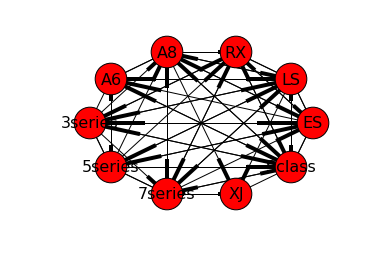

In [42]:
##Creating the network graph
G=nx.DiGraph()

#Creating the labels for the nodes and adding a node to the G object
labels = {}
opp_labels = {}
for i, value in enumerate(names):
    labels[i] = str(value)
    opp_labels[value] = i
    G.add_node(i) #Adding the nodes
    

#Create the list of tuples for edges
node_list = []
for index, pref in enumerate(averages_df.loc[:,'Positive']): #Positives
    if ~np.isnan(pref):
        node_list.append((pd.Series(averages_df.loc[:,'Node 1'])[index],pd.Series(averages_df.loc[:,'Node 2'])[index]))
        G.add_edge(*(opp_labels[pd.Series(averages_df.loc[:,'Node 1'])[index]],opp_labels[pd.Series(averages_df.loc[:,'Node 2'])[index]]))
for index, pref in enumerate(averages_df.loc[:,'Negative']): #Negatives
    if ~np.isnan(pref):
        node_list.append((pd.Series(averages_df.loc[:,'Node 2'])[index],pd.Series(averages_df.loc[:,'Node 1'])[index]))
        G.add_edge(*(opp_labels[pd.Series(averages_df.loc[:,'Node 2'])[index]],opp_labels[pd.Series(averages_df.loc[:,'Node 1'])[index]]))

pos = nx.circular_layout(G) #Positions

#nx.edges([(1,2),(1,0)])#node_list)

nx.draw_networkx_labels(G,pos, labels, font_size=16)
#nx.draw_networkx_nodes(G,pos,node_color='skyblue')
nx.draw(G,pos,node_size=1000)
###nx.Graph(node_list)

fig1 = plt.gcf()
plt.figure(num=None, figsize=(30,20))
#plt.savefig('network.png', dpi=100)

plt.show()
fig1.savefig('network.png', dpi=1000)

In [43]:
A = pd.DataFrame(index = names,columns = names)
A.ix['ES','ES']
A = A.fillna(0)
tuples  = averages_df
tuples.head()
tuples[:10]

length = len(tuples)
# write aggfunc
agg = pd.Series(index = names).fillna(0)
for i in range(length): 
    tup = tuples.ix[i]
    node1 = tup['Node 1']
    node2 = tup['Node 2']
    pos = abs(tup['Positive'])
    neg = abs(tup['Negative'])
    if ~np.isnan(pos):
        agg[node2] += pos #for weighted
#         agg[node2] += 1 # unweighted
    if ~np.isnan(neg):
        agg[node1] += neg
#         agg[node1] += 1 #for unweighted
    
for i in range(length):
    tup = tuples.ix[i]
    node1 = tup['Node 1']
    node2 = tup['Node 2']
    pos = abs(tup['Positive'])
    neg = abs(tup['Negative'])
    if ~np.isnan(pos):
        A.ix[node1, node2] += pos/agg[node2]
    if ~np.isnan(neg):
        A.ix[node2, node1] += neg/agg[node1]


A

,ES,LS,RX,A8,A6,3series,5series,7series,XJ,Sclass
ES,0.000000,0.184438,0.108287,0.050185,0.164533,0.217828,0.107708,0.000000,0.000000,0.110066
LS,0.197191,0.000000,0.173963,0.147874,0.286200,0.111323,0.123240,0.173987,0.504143,0.159951
RX,0.128456,0.095002,0.000000,0.000000,0.000000,0.248096,0.000000,0.044572,0.000000,0.054963
A8,0.174342,0.183967,0.105290,0.000000,0.027825,0.000000,0.000000,0.346931,0.037333,0.269924
A6,0.000000,0.028320,0.000000,0.043493,0.000000,0.000000,0.457744,0.000000,0.000000,0.091825
3series,0.157265,0.146447,0.111844,0.294456,0.160437,0.000000,0.101720,0.108068,0.000000,0.091818
5series,0.074867,0.065558,0.168992,0.078867,0.286202,0.315908,0.000000,0.109310,0.000000,0.085776
7series,0.143880,0.143497,0.180491,0.256334,0.000000,0.000000,0.209587,0.000000,0.168036,0.135676
XJ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104447,0.000000,0.000000
Sclass,0.124000,0.152771,0.151134,0.128791,0.074803,0.106845,0.000000,0.112686,0.290488,0.000000


In [44]:
#convergence 
x = [1] * 10
from sklearn.metrics import mean_squared_error
from math import sqrt
tol = 10
while tol > 1e-7: 
    old = np.dot(A,x)
    tol = sqrt(mean_squared_error(old, x))
    x = old
    print tol
    
final_rankscore = x

0.454409087554
0.198859282133
0.0554211311811
0.0168940560069
0.00494650279681
0.00148170172018
0.000392388244337
0.000112335648633
3.31188640054e-05
1.02312423151e-05
3.2111050387e-06
1.07047622761e-06
3.82335081814e-07
1.47624909792e-07
6.01190138359e-08


In [47]:
names = agg.index.values
ranks  = pd.Series(x, index = names)


price_dict = {'A6':20000, 'A8':12000, '3series':220000, '5series':60000, '7series':14000, 'XJ':6600, 'ES':135000, 'LS':30000, 'RX':120000, 'Sclass':25000}


price = pd.Series(price_dict,index = names)
final_rank_price = pd.concat([ranks,price],axis =1 )
final_rank_price.columns = ['rank','Sales']


# In[51]:

frp = final_rank_price
print frp['rank'].corr(frp['Sales'])

print frp

0.216539220636
             rank   Sales
ES       1.046782  135000
LS       1.448928   30000
RX       0.698458  120000
A8       1.233441   12000
A6       0.745096   20000
3series  1.283263  220000
5series  1.223977   60000
7series  1.211760   14000
XJ       0.126565    6600
Sclass   0.981730   25000
